In [1]:
###################################################################################################
# Project: 
#          
# Lenguaje: Python / jupyter
# Description:
#
# References: 
# Git Control:
# Author : Camilo Blanco Vargas - Year: 2020 
# Mail - Web:mail@camiloblanco.com - www.camiloblanco.com
###################################################################################################

In [20]:
# Import the necesary libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import timedelta
import Oanda_Manager as om

In [3]:
# Create an Oanda_Manager object to connect to Oanda API
account = pd.read_csv('Account_details.csv')
API_KEY=account.iloc[0, 0]
Account_ID=account.iloc[0, 1]
Oanda_URL=account.iloc[0, 2]
oandaAcc =  om.Oanda_Manager(API_KEY,Account_ID, Oanda_URL,{'Authorization': f'Bearer {API_KEY}'})
print(oandaAcc.account_list())

(200, {'accounts': [{'id': '101-004-19105515-001', 'tags': []}]})


In [4]:
# Retrieve the index data as a time-series dataframe usign a date range
#https://developer.oanda.com/rest-live-v20/instrument-df/#CandlestickGranularity
asset_name="SPX500_USD"
granularity="H4"
from_date = pd.to_datetime('5/16/2020')
to_date  = pd.to_datetime('5/16/2021')
candle_data = oandaAcc.get_candles_dates(asset_name, granularity,from_date,to_date)
candle_data.head()

,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c
time,,,,,,,,,,,,,
2020-05-17 21:00:00,5452.0,2858.6,2878.6,2855.6,2873.9,2858.2,2878.4,2855.4,2873.7,2858.9,2878.8,2855.8,2874.1
2020-05-18 01:00:00,3652.0,2874.0,2889.9,2872.8,2885.6,2873.7,2889.7,2872.4,2885.4,2874.4,2890.1,2873.1,2885.8
2020-05-18 05:00:00,4215.0,2885.3,2901.5,2879.4,2896.9,2885.1,2901.3,2879.1,2896.7,2885.5,2901.7,2879.6,2897.1
2020-05-18 09:00:00,5320.0,2896.8,2939.0,2889.7,2938.1,2896.5,2938.7,2889.5,2937.9,2897.1,2939.4,2889.9,2938.3
2020-05-18 13:00:00,7327.0,2937.8,2957.6,2929.0,2950.6,2937.6,2957.5,2928.9,2950.4,2938.0,2957.8,2929.2,2950.7


In [5]:
# Print the info of the resulting timeIndex dataframe
candle_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1541 entries, 2020-05-17 21:00:00 to 2021-05-14 17:00:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  1541 non-null   float64
 1   mid_o   1541 non-null   float64
 2   mid_h   1541 non-null   float64
 3   mid_l   1541 non-null   float64
 4   mid_c   1541 non-null   float64
 5   bid_o   1541 non-null   float64
 6   bid_h   1541 non-null   float64
 7   bid_l   1541 non-null   float64
 8   bid_c   1541 non-null   float64
 9   ask_o   1541 non-null   float64
 10  ask_h   1541 non-null   float64
 11  ask_l   1541 non-null   float64
 12  ask_c   1541 non-null   float64
dtypes: float64(13)
memory usage: 168.5 KB


In [6]:
# Describe the date
index_stats = candle_data.describe()
index_stats = index_stats.transpose()
index_stats

,count,mean,std,min,25%,50%,75%,max
volume,1541.0,17481.737833,22907.768425,533.0,4765.0,9033.0,20774.0,203425.0
mid_o,1541.0,3582.434328,346.020971,2858.6,3309.1,3567.3,3864.9,4242.8
mid_h,1541.0,3593.070668,344.681172,2878.6,3324.4,3575.0,3880.8,4245.4
mid_l,1541.0,3571.005711,347.457450,2855.6,3300.6,3554.0,3856.1,4239.6
mid_c,1541.0,3583.230759,345.717418,2873.9,3309.7,3567.7,3865.0,4242.9
bid_o,1541.0,3582.180337,346.014759,2858.2,3308.9,3567.0,3864.6,4242.5
bid_h,1541.0,3592.874173,344.684694,2878.4,3324.2,3574.8,3880.6,4245.2
bid_l,1541.0,3570.766191,347.452410,2855.4,3300.4,3553.5,3855.9,4239.4
bid_c,1541.0,3583.030175,345.721315,2873.7,3309.5,3567.5,3864.8,4242.7
ask_o,1541.0,3582.688189,346.026928,2858.9,3309.3,3567.6,3865.2,4243.1


<AxesSubplot:xlabel='time'>

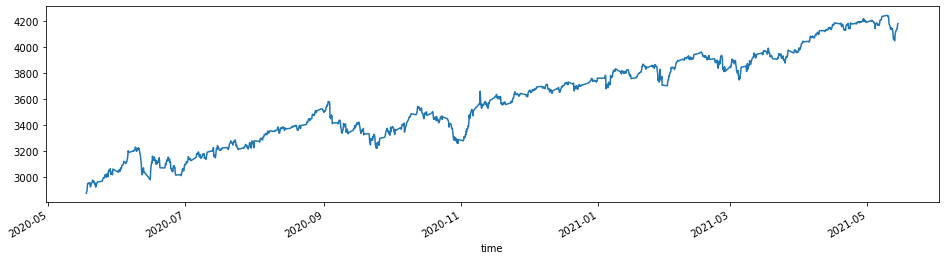

In [7]:
# Plot the medium closing price
plt.figure(figsize=(16,4))
candle_data['mid_c'].plot()

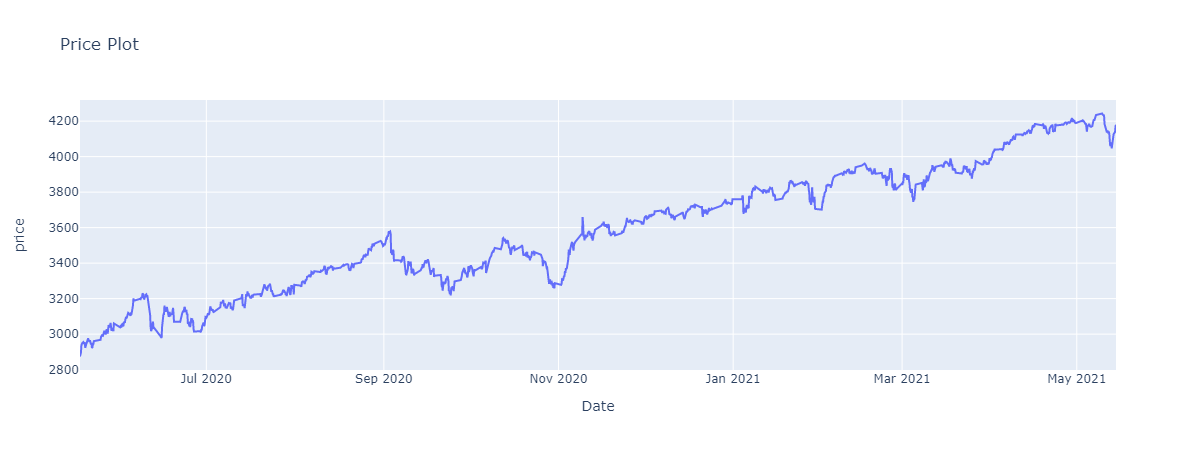

In [13]:
sp500_data = go.Scatter(x=candle_data.index, y=candle_data['mid_c'])
layout = go.Layout(title='Price Plot', xaxis=dict(title='Date'), yaxis=dict(title='price'))
fig = go.Figure(data=[sp500_data], layout=layout)
fig.show()

In [23]:
from_date = pd.to_datetime('1/1/2003')
to_date  = pd.to_datetime('5/16/2021')
to_date - from_date



Timedelta('6710 days 00:00:00')

In [21]:
from_date+ timedelta(days=180)

Timestamp('2020-11-12 00:00:00')

In [24]:
+6710/365

18.383561643835616

In [26]:
df1 = pd.DataFrame({'player': ['A', 'B', 'C', 'D', 'E'],
                    'points':[12, 5, 13, 17, 27]})

df2 = pd.DataFrame({'player': ['F', 'G', 'H', 'I', 'J'],
                    'points':[24, 26, 27, 27, 12]})

df3 = pd.concat([df1,df2])


,player,points
0,A,12
1,B,5
2,C,13
3,D,17
4,E,27
0,F,24
1,G,26
2,H,27
3,I,27
4,J,12


In [34]:
from_date = pd.to_datetime('1/1/2003')
to_date  = pd.to_datetime('12/31/2003')
candle_data_2003 = oandaAcc.get_candles_dates(asset_name, granularity,from_date,to_date)
from_date = pd.to_datetime('1/1/2004')
to_date  = pd.to_datetime('12/31/2004')
candle_data_2004 = oandaAcc.get_candles_dates(asset_name, granularity,from_date,to_date)
from_date = pd.to_datetime('1/1/2005')
to_date  = pd.to_datetime('12/31/2005')
candle_data_2005 = oandaAcc.get_candles_dates(asset_name, granularity,from_date,to_date)
from_date = pd.to_datetime('1/1/2006')
to_date  = pd.to_datetime('12/31/2006')
candle_data_2006 = oandaAcc.get_candles_dates(asset_name, granularity,from_date,to_date)
candle_data_2003_2006 = pd.concat([candle_data_2003,candle_data_2004,candle_data_2005,candle_data_2006])


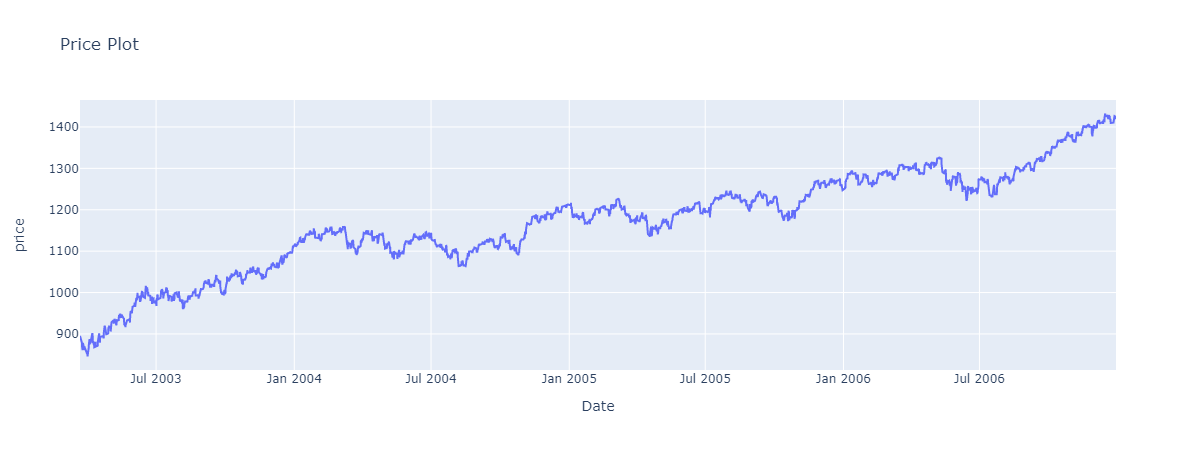

In [36]:
sp500_data = go.Scatter(x=candle_data_2003_2006.index, y=candle_data_2003_2006['mid_c'])
layout = go.Layout(title='Price Plot', xaxis=dict(title='Date'), yaxis=dict(title='price'))
fig = go.Figure(data=[sp500_data], layout=layout)
fig.show()